In [1]:
import velocity_metrics.lagrangian.drifters as drifters
import velocity_metrics.lagrangian.cumulative_distance as sde
import velocity_metrics.utils.constant as const  
import os
import warnings
import sys
import datetime
warnings.filterwarnings("ignore")
#sys.path.append('/Odyssey/private/t22picar/2024_DC_WOC-ESA/')
import json

import netCDF4
import numpy
import matplotlib
# import cartopy
import glob
import os
import sys
import datetime
from matplotlib import pyplot
import pickle
import gzip
from tqdm import tqdm
from typing import Optional, Tuple
import logging
logger = logging.getLogger(__name__)
import matplotlib.pyplot
import cartopy.crs as ccrs

box_cal = [-135, -115, 35, 50]
box_med = [-5.6, 16.8, 34.6, 44.6]
box_gs = [-80, -43, 25, 46.5 ]
box_agulhas = [11, 35, -44, -30]
box_NA = [-40, 0, 48, 68]
box_HW = [-170, -120, 10, 40]

from plot_lagrangian import *

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
dico_color = {
    "globcurrent_15m_4th": "b",
    "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet": "g",
    "unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet": "teal",
    "neurost_sst_ssh_15m_10th": "violet",
    # Ajoutez d'autres correspondances ici
}

In [20]:
def plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_neurost,dic_drif,box):
    lon_min, lon_max, lat_min, lat_max = box
    alpha=0.4
    map_back = get_sst_L4_8th(date_target,box)
    list_advection, dic_all = get_list_advection(date_target,fictive_traj)
    list_advection_neurost, dic_all_neurost = get_list_advection(date_target,fictive_traj_neurost)

    figure = pyplot.figure(figsize=(8, 8))
    proj=ccrs.PlateCarree()

    for advection,advection_neurost in zip(list_advection,list_advection_neurost):
        
        #print(advection)

        lon_f_n, lat_f_n, hrtime_n, dic_attr_n,lon_d,lat_d = get_fictive_traj(advection_neurost,dic_all_neurost,dic_drif)

        lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,dic_drif)
        
        #print(hrtime)
        
        proj=ccrs.PlateCarree()
        
        ax0 = pyplot.subplot(111, projection=proj)


        extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                    numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
        
        gl = ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.3, xlocs=range(-180, 181, 4), ylocs=range(-90, 91, 4))
            # adjust labels to taste
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = True
        gl.left_labels = True

        ax0.add_feature(
        cfeature.LAND,
        facecolor='lightgray',  # Couleur de remplissage
        edgecolor='black',      # Couleur des bordures (optionnel)
        zorder=2                # Ordre de dessin (0 = en arrière-plan)
        )

        ax0.coastlines(resolution='10m', lw=0.5)
        
        for pa in range(0, numpy.shape(lon_f)[1], 1):
            ax0.plot(lon_f[:, pa], lat_f[:, pa], dico_color.get(dic_attr["data_type"],'b'), transform=proj,alpha=alpha,zorder=5)
            ax0.plot(lon_f_n[:, pa], lat_f_n[:, pa], dico_color.get(dic_attr_n["data_type"],'g'), transform=proj,alpha=alpha,zorder=5)
        
        """"
        for pa in range(0, numpy.shape(lon_f)[1], 1):
            ax0.plot(lon_f[:, pa], lat_f[:, pa], dico_color.get(dic_attr["data_type"],'g'), transform=proj,alpha=alpha,zorder=5)

        for pa in range(0, numpy.shape(lon_f_n)[1], 1):
            ax0.plot(lon_f_n[:, pa], lat_f_n[:, pa], dico_color.get(dic_attr_n["data_type"],'g'), transform=proj,alpha=alpha,zorder=5)
        """

        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1,zorder=10)
        ax0.scatter(lon_d[0],lat_d[0], transform=proj,alpha=1,c='k',s=40,marker='o',zorder=10)
        ax0.scatter(lon_d[-1],lat_d[-1], transform=proj,alpha=1,c='k',s=40,marker='^',zorder=10)
    
    sst_cm = ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)

    ax0.plot(lon_f[0, 0], lat_f[0, 0], dico_color.get(dic_attr["data_type"],'b'), transform=proj,alpha=1,label=dico_label.get(dic_attr["data_type"], dic_attr["data_type"]))
    ax0.plot(lon_f_n[0, 0], lat_f_n[0, 0], dico_color.get(dic_attr_n["data_type"],'g'), transform=proj,alpha=1,label=dico_label.get(dic_attr_n["data_type"], dic_attr_n["data_type"]))
    ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1,label="Drifter")

    ax0.set_ylim(lat_min,lat_max)
    ax0.set_xlim(lon_min,lon_max)

    #ax0.legend()
    ax0.set_title(f"First date advection : {date_target}")

    #get size and extent of axes:
    axpos = ax0.get_position()
    pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
    pos_y = axpos.y0
    cax_width = 0.02
    cax_height = axpos.height

    pos_cax = figure.add_axes([pos_x,pos_y,cax_width,cax_height])
    cbar=matplotlib.pyplot.colorbar(sst_cm, cax=pos_cax, orientation='vertical')
    cbar.set_label("SST at released day + 5d (K)")
        
    #cbar = matplotlib.pyplot.colorbar(sst_cm, ax=ax0, orientation='vertical', pad=0.08,shrink=0.35)


In [21]:
base_output="../../"
depth=15
depth_formatted = "{:02}".format(depth)
input_dict = f'{base_output}metric/dictionary/'
input_drifter = "/Odyssey/private/t22picar/data/drifters/AOML/"
drifter_list = [input_drifter + f'Drifters_AOML_GL_{depth_formatted}m_20190101T000000Z_20200101T000000Z.pyo.gz']

input_lagrangian_position = '/Odyssey/private/t22picar/data/drifters/AOML/json/'
region="Hawai"
path_drifter_position = input_lagrangian_position + f'Fictive_pos_Drifters_AOML_region_{region}_{depth_formatted}m_20190101T000000Z_20200101T000000Z.json' 
path_drifter_param = input_dict + 'drifters_parameters.ini'

xp_name_2="unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet"
xp_name="globcurrent_15m_4th" #"GC_15m_4th_h"
#xp_name="neurost_sst_ssh_15m_10th"

if region=="T1":
    region="Agulhas"

fictive_traj = f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name}/metric_15m/{region}/{xp_name}_region_{region}_dep1.pyo.gz"
fictive_traj_2=f"/Odyssey/private/t22picar/multivar_drifter/rec/{xp_name_2}/metric_15m/{region}/{xp_name_2}_region_{region}_dep1.pyo.gz"

if 'gz' in os.path.splitext(drifter_list[0])[-1]:
    with gzip.open(drifter_list[0], 'rb') as f:
        dic_drif = pickle.load(f)

number of drifter : 39
number of drifter : 39
Pb with hrtime
Pb with hrtime


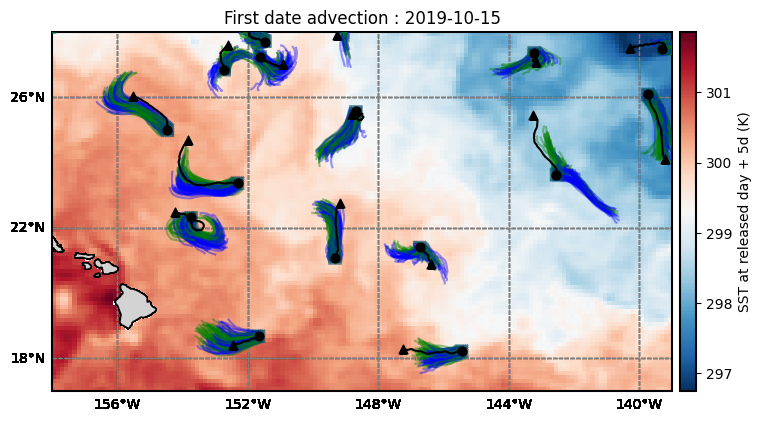

In [22]:
box_HW = [-158, -139, 17, 28]

date_target = "2019-10-15" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

pyplot.savefig(f"/Odyssey/private/t22picar/plot_article/figures/Lagrangian_traj_HW.png", dpi = 300,bbox_inches='tight')


In [ ]:
date_target = "2019-08-16"
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 50
number of drifter : 50
Pb with hrtime
Pb with hrtime
Pb with hrtime
Pb with hrtime


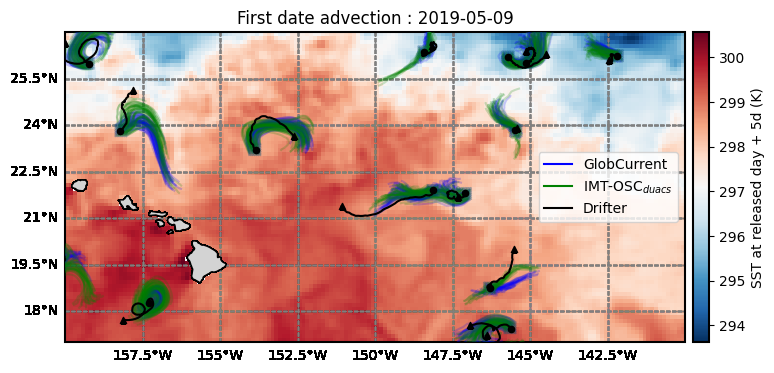

In [22]:
box_HW = [-160, -140, 17, 27]

date_target = "2019-05-09" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 40
number of drifter : 40
Pb with hrtime
Pb with hrtime


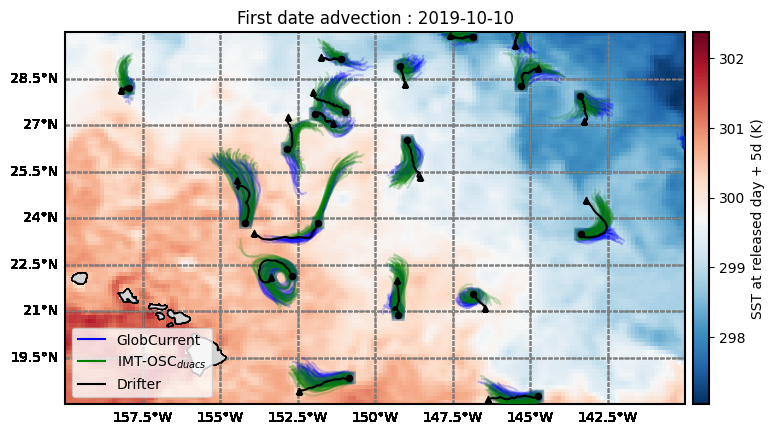

In [ ]:
box_HW = [-160, -140, 17, 28]

date_target = "2019-10-10" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 37
number of drifter : 37
Pb with hrtime
Pb with hrtime
Pb with hrtime
Pb with hrtime


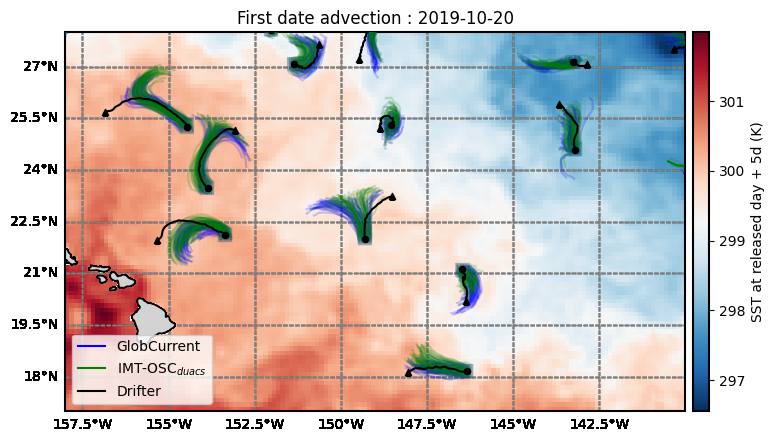

In [55]:
box_HW = [-158, -140, 17, 28]
date_target = "2019-10-20" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 39
number of drifter : 39
Pb with hrtime
Pb with hrtime
Pb with hrtime
Pb with hrtime


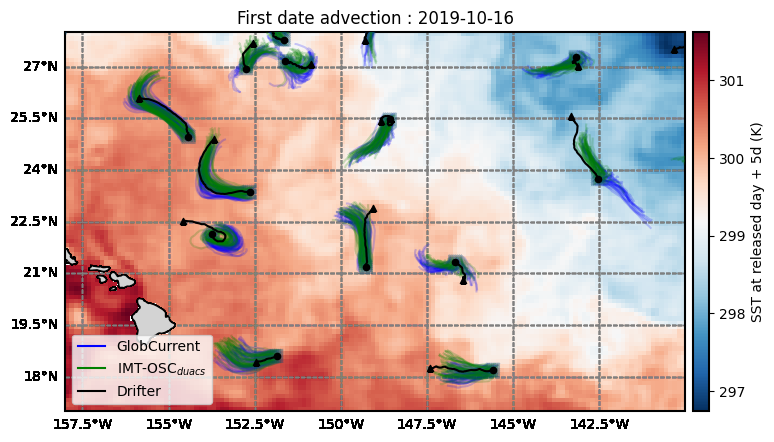

In [53]:
box_HW = [-158, -140, 17, 28]
date_target = "2019-10-16" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 39
number of drifter : 39
Pb with hrtime
Pb with hrtime


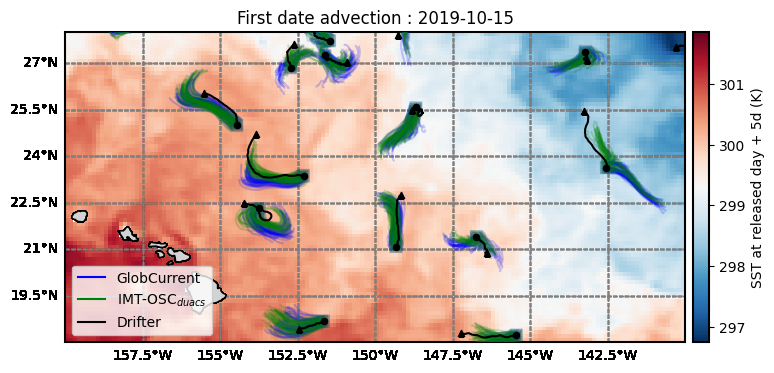

number of drifter : 39
number of drifter : 39


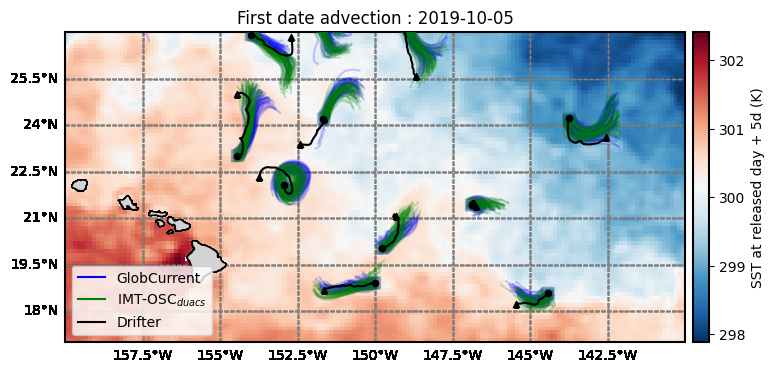

In [48]:
box_HW = [-160, -140, 17, 27]

date_target = "2019-10-05" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 43
number of drifter : 43


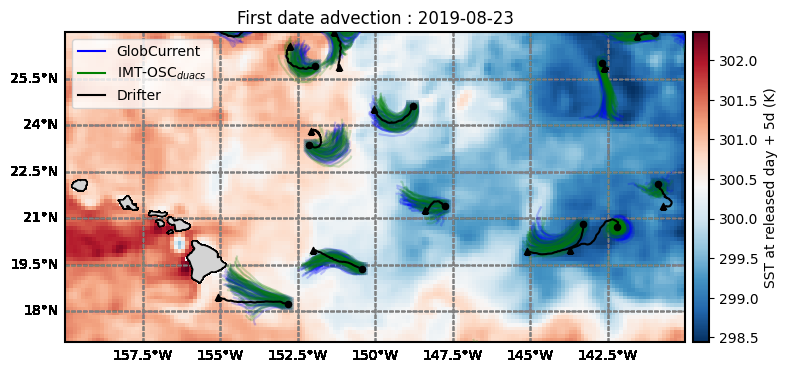

In [39]:
box_HW = [-160, -140, 17, 27]

date_target = "2019-08-23" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 47
number of drifter : 47
Pb with hrtime
Pb with hrtime
Pb with hrtime
Pb with hrtime


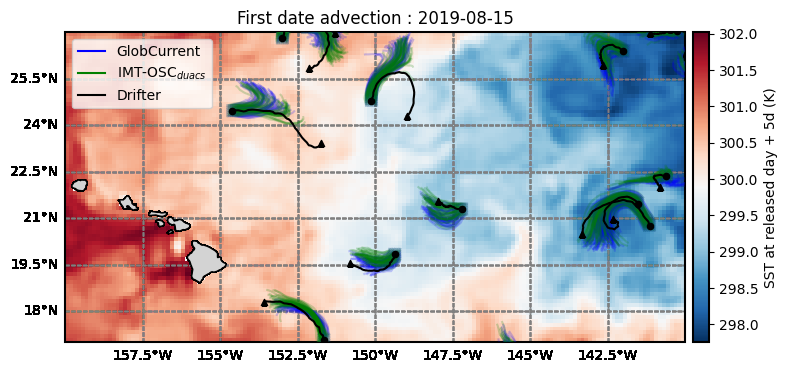

In [42]:
box_HW = [-160, -140, 17, 27]

date_target = "2019-08-15" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 44
number of drifter : 44


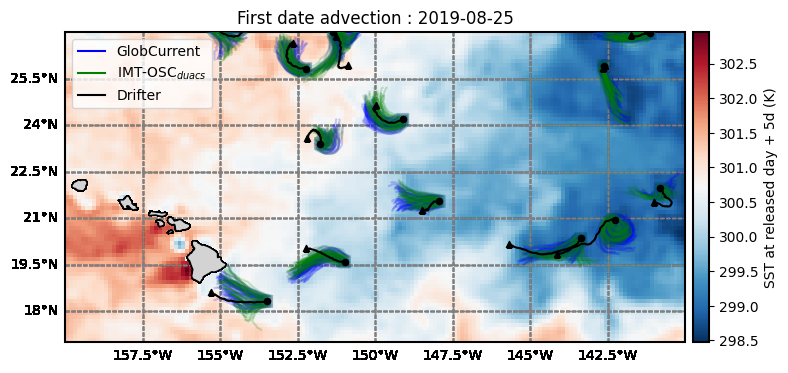

In [32]:
box_HW = [-160, -140, 17, 27]

date_target = "2019-08-25" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 44
number of drifter : 44
Pb with hrtime
Pb with hrtime


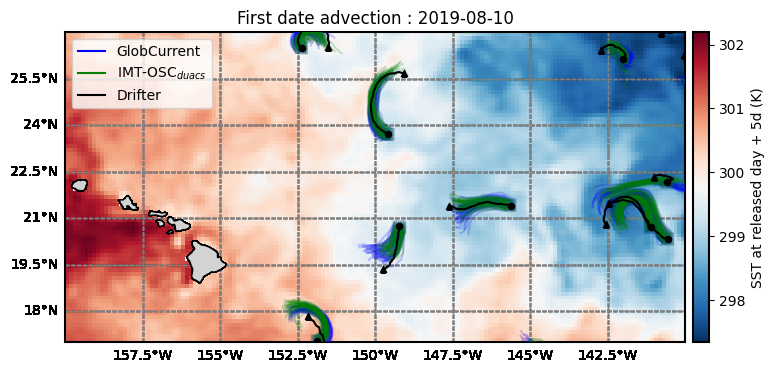

In [40]:
date_target = "2019-08-10" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 44
number of drifter : 44
Pb with hrtime
Pb with hrtime
Pb with hrtime
Pb with hrtime


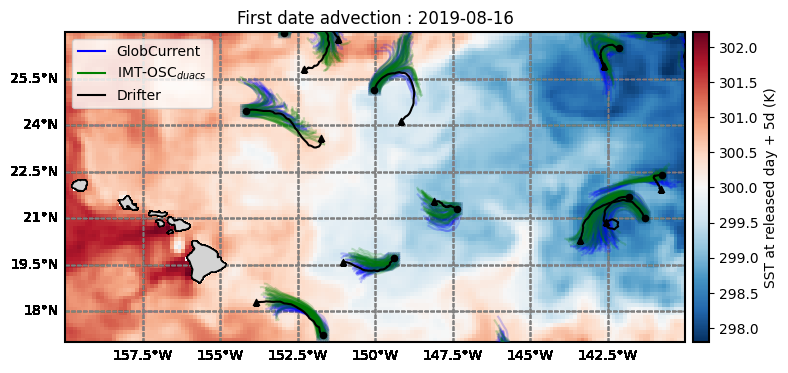

In [46]:
date_target = "2019-08-16"
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_HW)

number of drifter : 10
number of drifter : 10


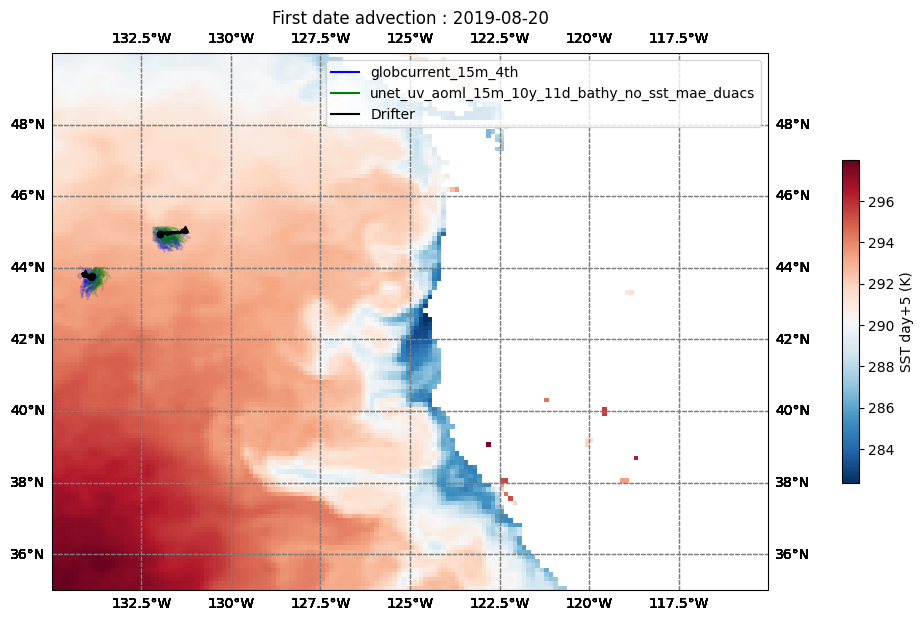

In [ ]:
date_target = "2019-08-20"
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_cal)

number of drifter : 10
number of drifter : 10


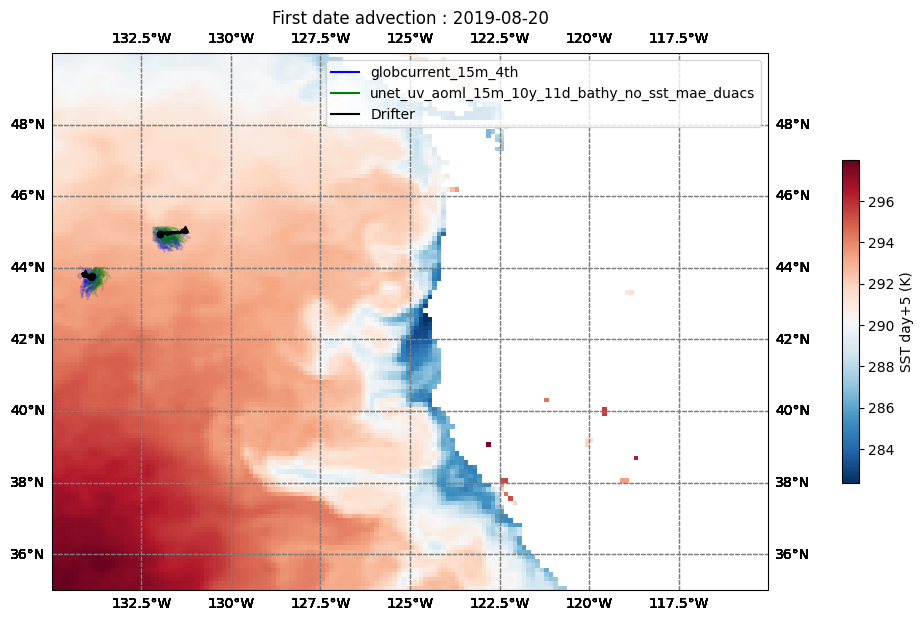

In [73]:
date_target = "2019-08-20"
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_cal)

number of drifter : 10
number of drifter : 10


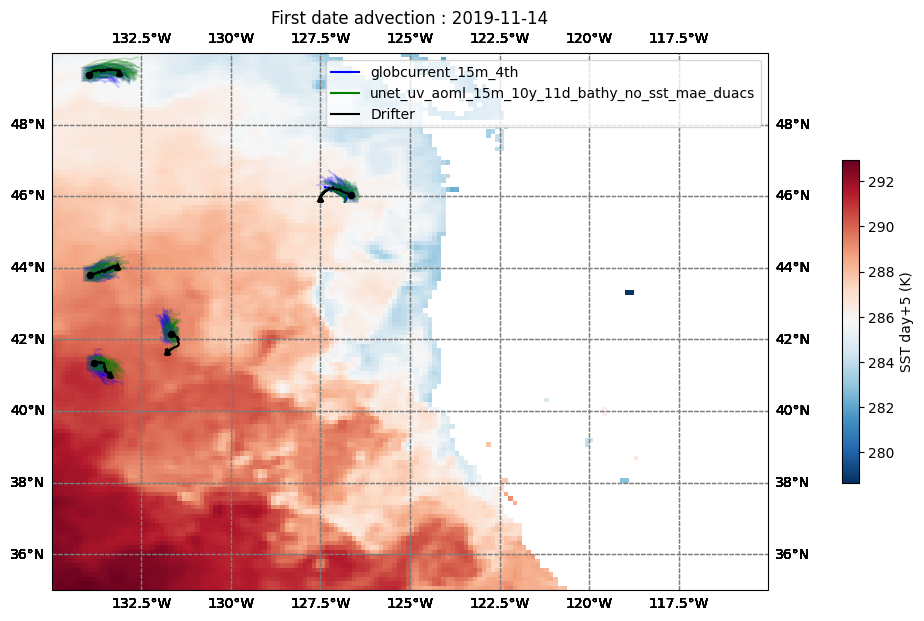

In [70]:
date_target = "2019-11-14"
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_cal)

number of drifter : 11
number of drifter : 11


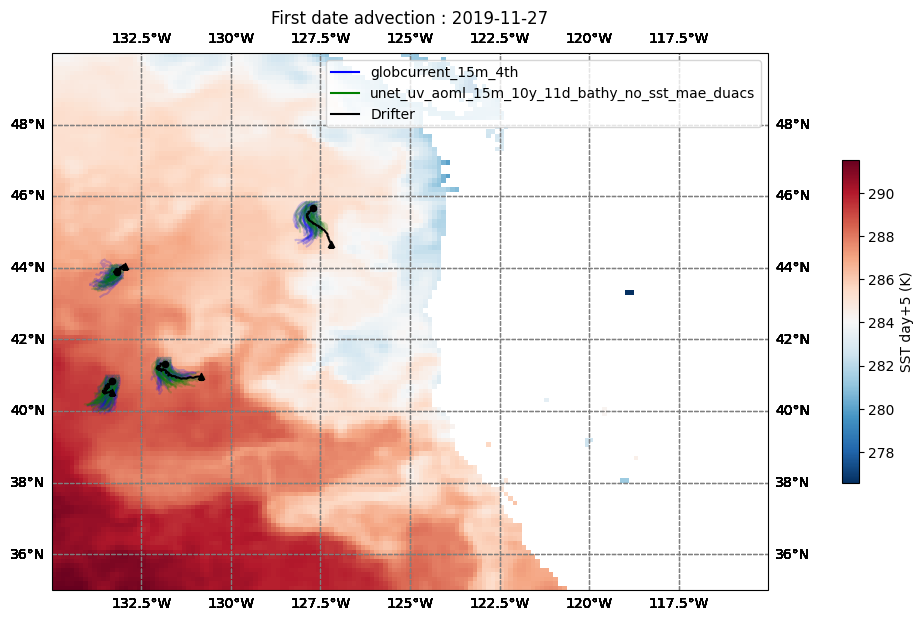

In [65]:
date_target = "2019-11-27" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_cal)

number of drifter : 11
number of drifter : 11


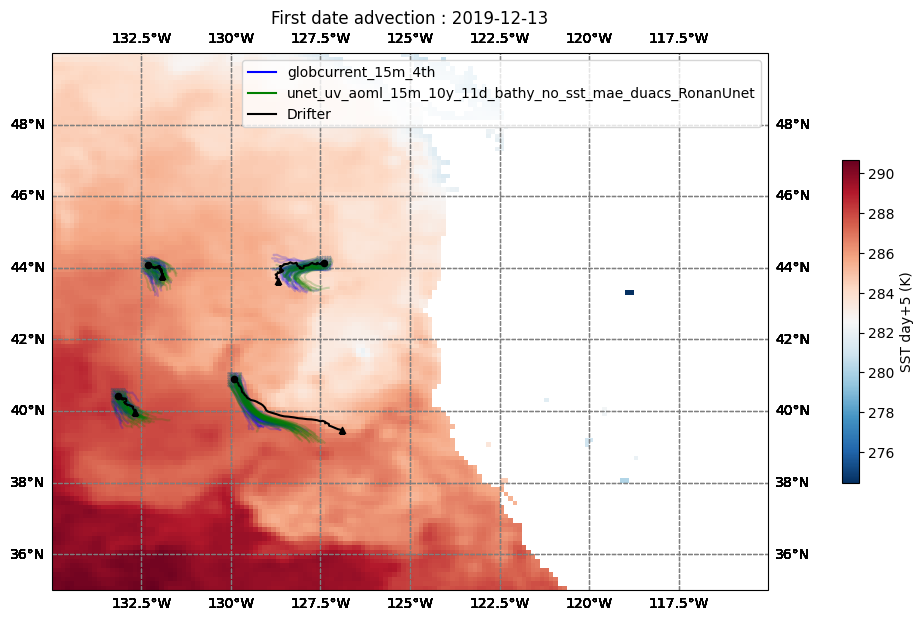

In [4]:
date_target = "2019-12-13" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_cal)

number of drifter : 11
number of drifter : 11


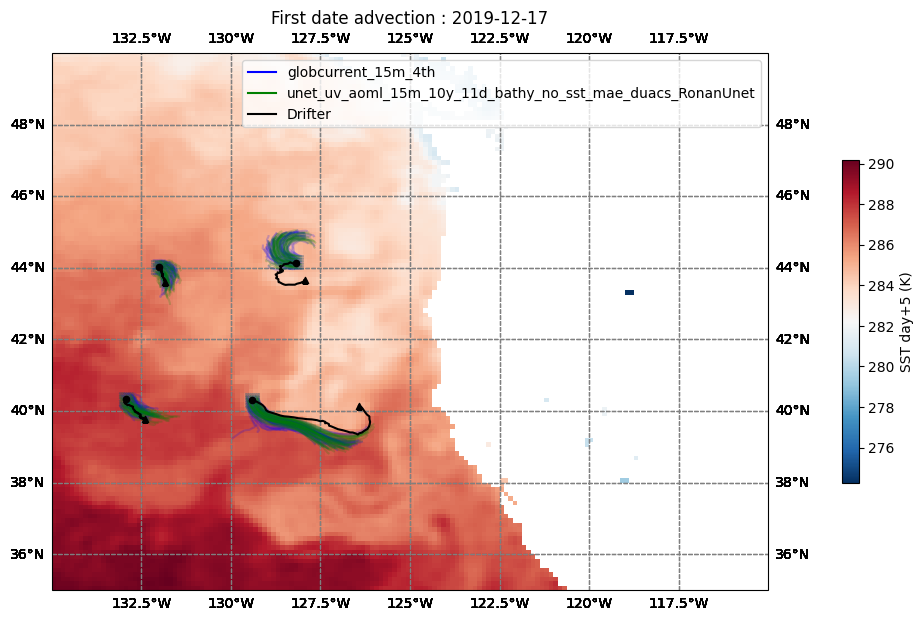

In [5]:
date_target = "2019-12-17" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_cal)

number of drifter : 11
number of drifter : 11


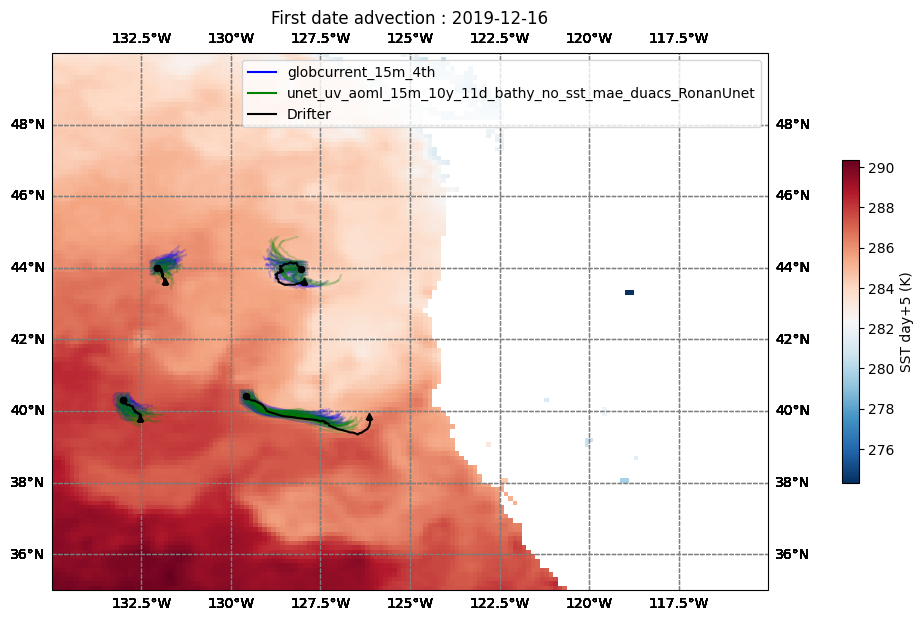

In [6]:
date_target = "2019-12-16" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_cal)

number of drifter : 11
number of drifter : 11


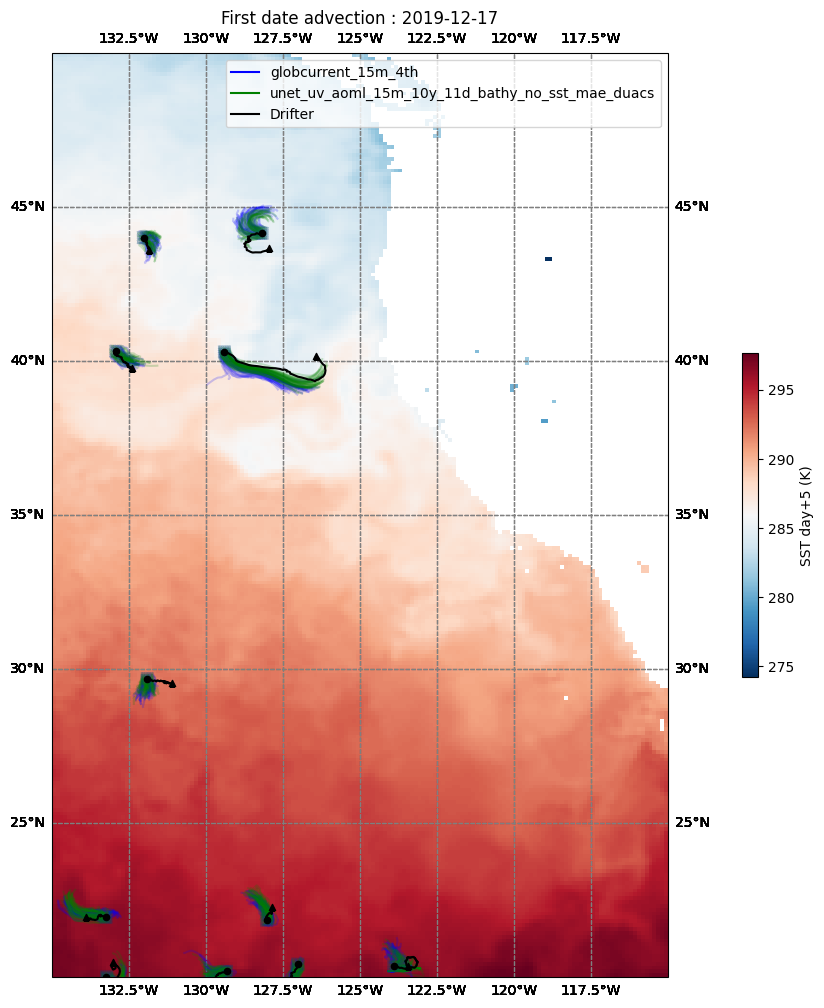

In [37]:
date_target = "2019-12-17" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2,dic_drif,box_cal)


number of drifter : 7

number of drifter : 7
Pb with hrtime
Pb with hrtime


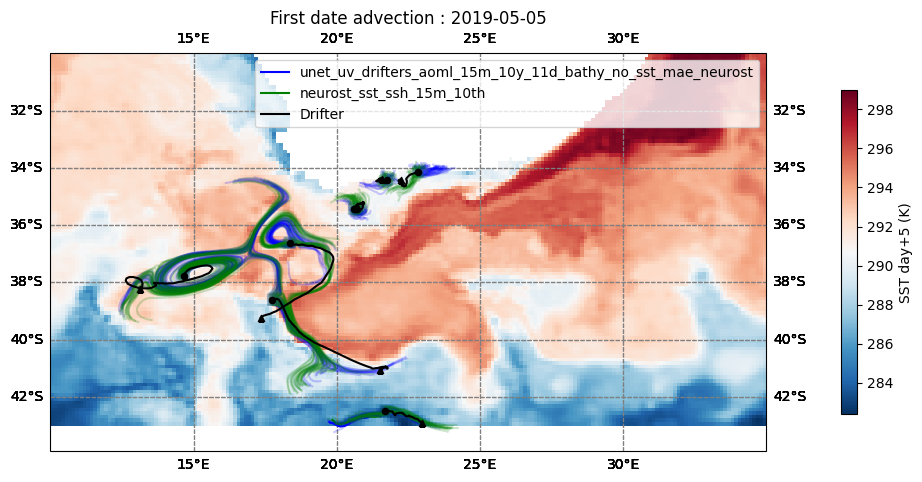

In [26]:
date_target = "2019-05-05" 
plot_lagrangian_traj(date_target,fictive_traj,fictive_traj_2)

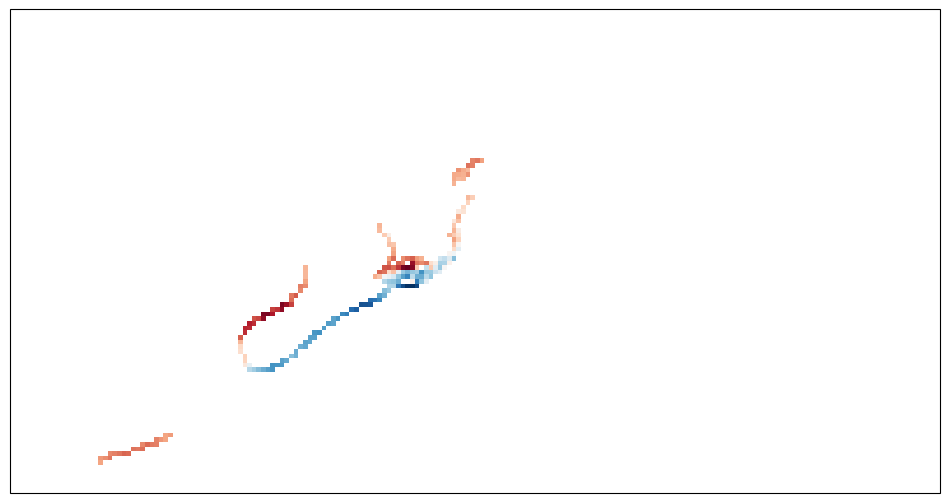

In [54]:
date_target = "2019-03-24" 

date_target_0 = datetime.datetime.strptime(date_target, "%Y-%m-%d") 
date_target_1 = date_target_0 + datetime.timedelta(days=10)
#result_filepath = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_4th.nc"
result_filepath = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_8th_2010_2023.nc"
map = xarray.open_dataset(result_filepath).sel(time=slice(date_target_0,date_target_1)).sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
map=map.mean(dim="time", skipna=True)

figure = pyplot.figure(figsize=(12, 12))
proj=ccrs.PlateCarree()
ax0 = pyplot.subplot(111, projection=proj)
ax0.pcolormesh(map.lon,map.lat,map.u_drifter,cmap=matplotlib.pyplot.cm.RdBu_r)

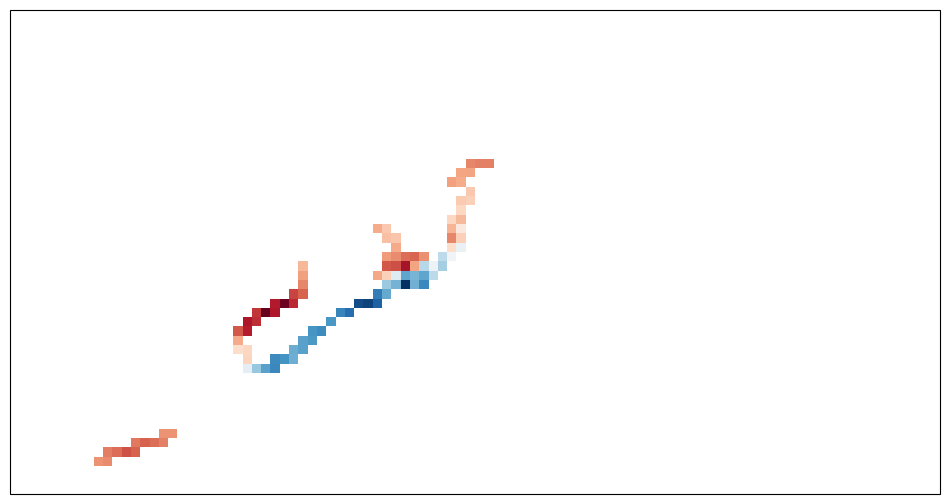

In [55]:
date_target = "2019-03-24" 

date_target_0 = datetime.datetime.strptime(date_target, "%Y-%m-%d") 
date_target_1 = date_target_0 + datetime.timedelta(days=10)
result_filepath = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_4th.nc"
#result_filepath = "/Odyssey/private/t22picar/data/drifters/daily_uv/drifters_uv_aoml_15m_8th_2010_2023.nc"
map = xarray.open_dataset(result_filepath).sel(time=slice(date_target_0,date_target_1)).sel(lon=slice(lon_min,lon_max)).sel(lat=slice(lat_min,lat_max))
map=map.mean(dim="time", skipna=True)

figure = pyplot.figure(figsize=(12, 12))
proj=ccrs.PlateCarree()
ax0 = pyplot.subplot(111, projection=proj)
ax0.pcolormesh(map.lon,map.lat,map.u_drifter,cmap=matplotlib.pyplot.cm.RdBu_r)


In [327]:
date_target = "2019-04-12" 
plot_lagrangian_traj(date_target)

TypeError: plot_lagrangian_traj() missing 2 required positional arguments: 'fictive_traj' and 'fictive_traj_neurost'


number of drifter : 5

number of drifter : 5


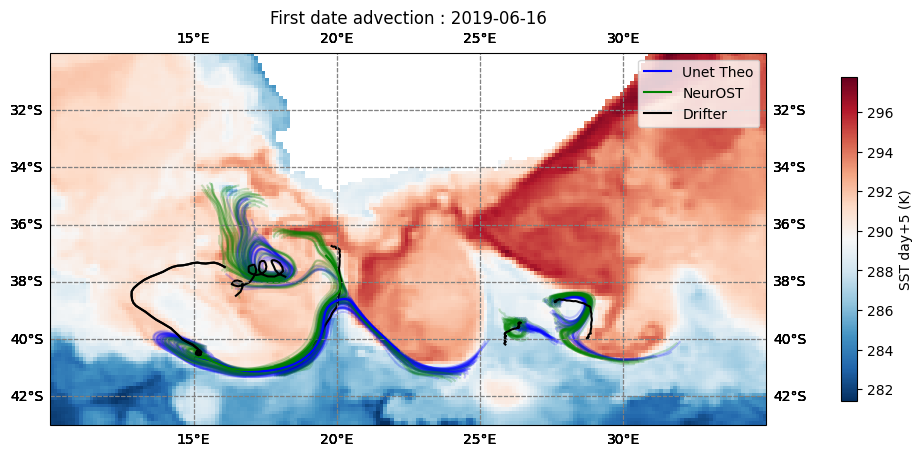

In [12]:
date_target = "2019-01-12" 
plot_lagrangian_traj(date_target)

TypeError: plot_lagrangian_traj() missing 2 required positional arguments: 'fictive_traj' and 'fictive_traj_neurost'


number of drifter : 6

number of drifter : 6


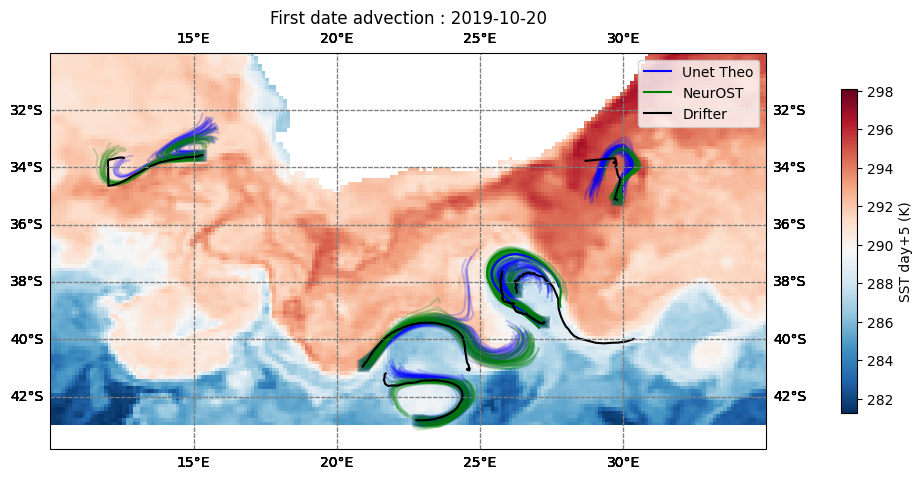

In [ ]:

plot_lagrangian_traj(date_target)


number of drifter : 7


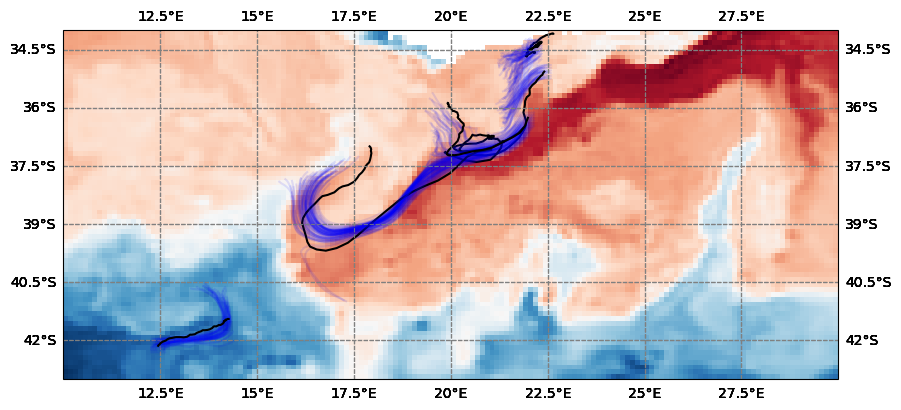

In [ ]:

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 5


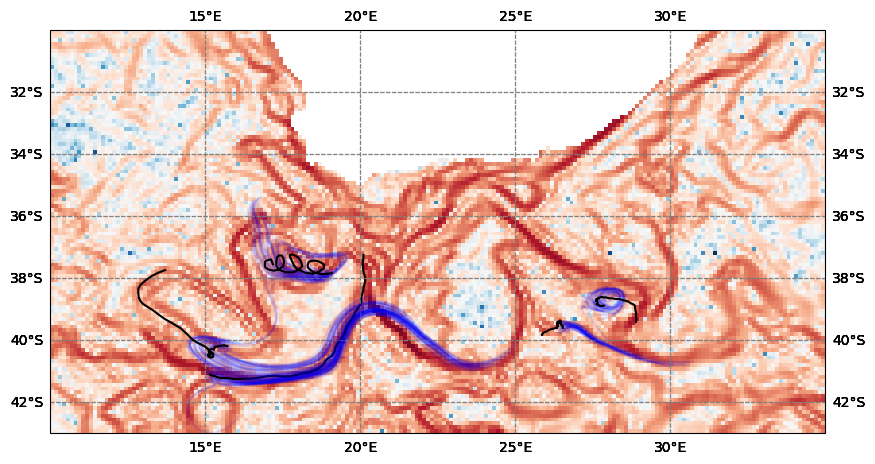

In [332]:
date_target = "2019-06-13" 
alpha=0.1

map_back = get_sst_MW(date_target)
#map_back = get_sst_L3(date_target)
map_back = get_sst_L4_8th_log(date_target)

list_advection, dic_all = get_list_advection(date_target,fictive_traj)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 5


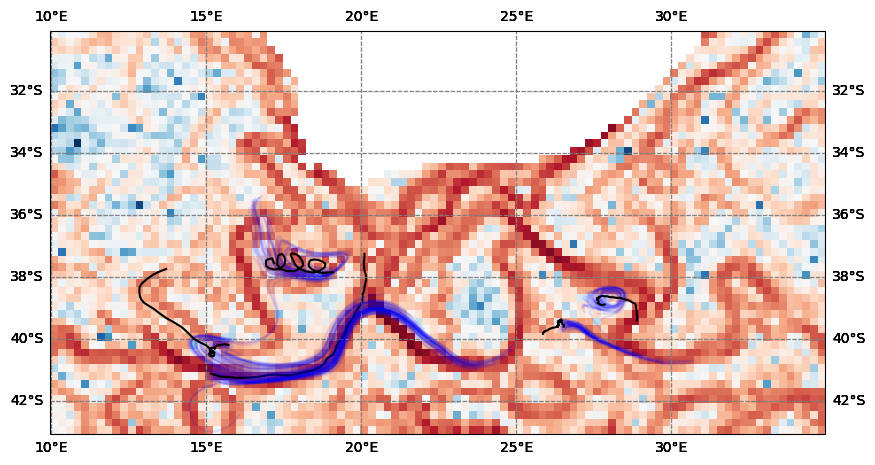

In [331]:
date_target = "2019-06-13" 
alpha=0.1

map_back = get_sst_MW(date_target)
#map_back = get_sst_L3(date_target)
map_back = get_sst_L4_4th_log(date_target)

list_advection, dic_all = get_list_advection(date_target,fictive_traj)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 6


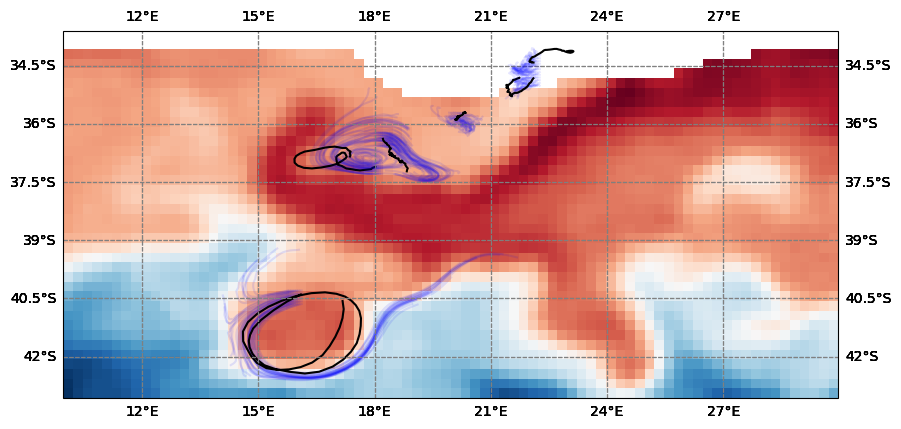

In [266]:
date_target = "2019-04-12" 
alpha=0.1

map_back = get_sst_MW(date_target)
#map_back = get_sst_L3(date_target)
#map_back = get_sst_L4_8th_log(date_target)

list_advection, dic_all = get_list_advection(date_target)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 6


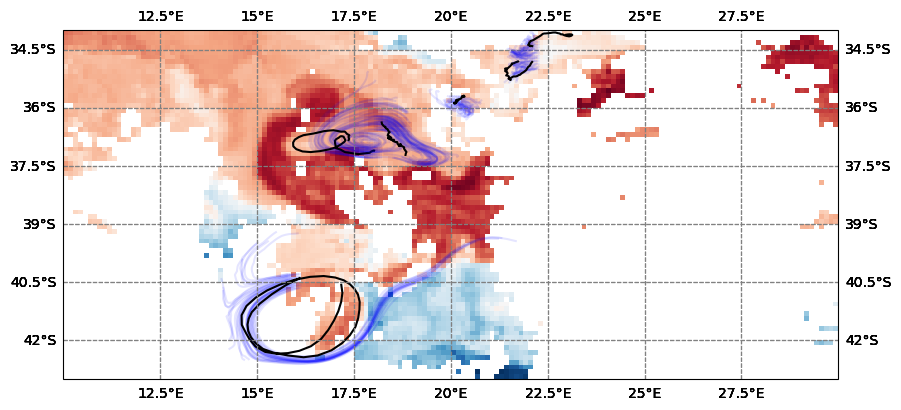

In [263]:
date_target = "2019-04-12" 
alpha=0.1

#map_back = get_sst_L3(date_target)
map_back = get_sst_L3_8th(date_target)

list_advection, dic_all = get_list_advection(date_target)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 6


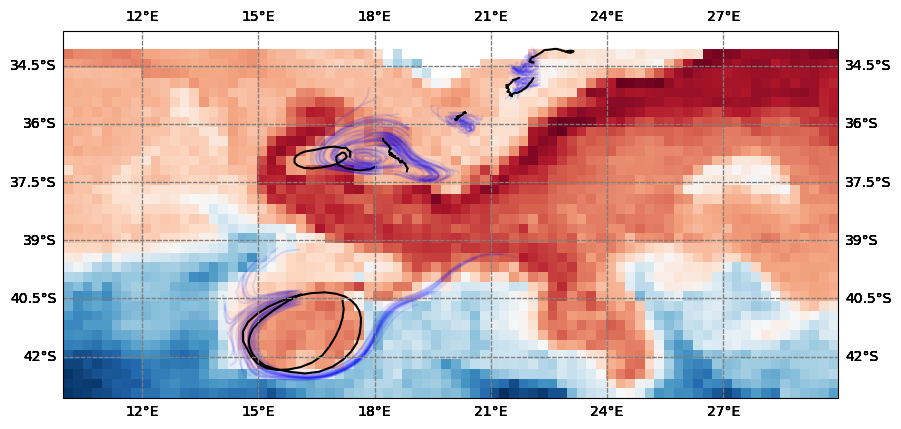

In [265]:
date_target = "2019-04-12" 
#map_back = get_sst_L3(date_target)
map_back = get_sst_L4_4th(date_target)

list_advection, dic_all = get_list_advection(date_target)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)


number of drifter : 6


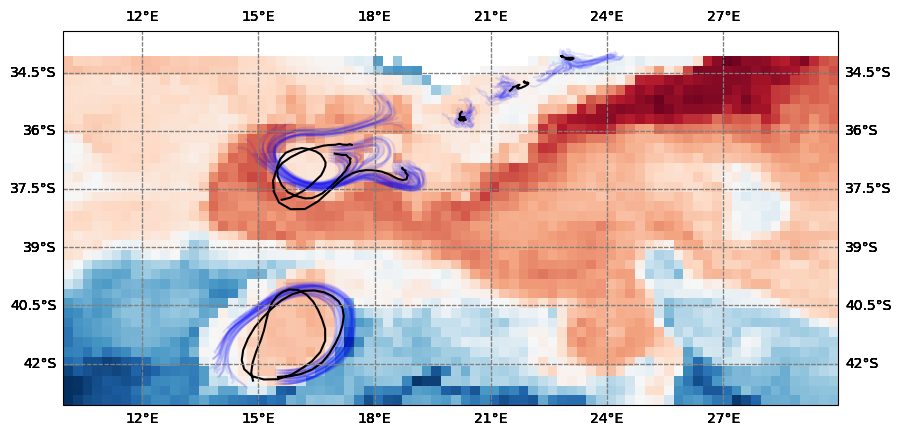

In [270]:
date_target = "2019-04-20" 
#map_back = get_sst_L3(date_target)
map_back = get_sst_L4_4th(date_target)

list_advection, dic_all = get_list_advection(date_target)

figure = pyplot.figure(figsize=(10, 10))

for advection in list_advection:

    lon_f, lat_f, hrtime, dic_attr,lon_d,lat_d = get_fictive_traj(advection,dic_all,drifter_list)
    proj=ccrs.PlateCarree()
    
    ax0 = pyplot.subplot(111, projection=proj)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
                numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                        alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b',alpha=0.5)
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj,alpha=alpha)

    if proj is None:
        ax0.plot(lon_d, lat_d, '-k',alpha=1)
    else:
        ax0.plot(lon_d, lat_d, '-k', transform=proj,alpha=1)

    ax0.pcolormesh(map_back.lon,map_back.lat,map_back,cmap=matplotlib.pyplot.cm.RdBu_r)

In [199]:
def plot_trajectory(file_out: str, lon_f: numpy.ndarray, lat_f: numpy.ndarray,
                    lon_d: numpy.ndarray, lat_d: numpy.ndarray,
                    time: numpy.ndarray, sde: numpy.ndarray,
                    proj: Optional = None, isscore: bool = True
                    ) -> pyplot.figure():

_IncompleteInputError: incomplete input (1970997830.py, line 5)

In [ ]:
def process_all_ide(input_path: str, drifter_pyo: str, dir_out: str,
                    file_out: str, isplot: Optional[bool] = True,
                    projection: Optional[str] = None,) -> dict:
    if 'gz' in os.path.splitext(drifter_pyo[0])[-1]:
        with gzip.open(drifter_pyo[0], 'rb') as f:
            dic_drif = pickle.load(f)
    else:
        with open(drifter_pyo[0], 'rb') as f:
            dic_drif = pickle.load(f)
    if os.path.isdir(input_path):
        input_netcdf = True
        list_advection = glob.glob(os.path.join(input_path, '*nc'))
    else:
        try:
            if 'gz' in os.path.splitext(input_path)[-1]:
                with gzip.open(input_path, 'rb') as f:
                    dic_all = pickle.load(f)
            else:
                with open(input_path, 'rb') as f:
                    dic_all = pickle.load(f)
        except pickle.UnpicklingError:
            logger.error(f'{input_path} should be a pickle object')
            sys.exit(1)
        input_netcdf = False
        list_advection = list(dic_all.keys())
    os.makedirs(dir_out, exist_ok=True)
    dic_result = {}
    for ifile in tqdm(list_advection[:]):
        if input_netcdf is True:
            _fname = os.path.basename(ifile)
            _fname_out = os.path.splitext(_fname)[0]
            logging.debug(f'Read Netcdf fictive trajectory {ifile}')
            hrlon, hrlat, hrtime, dic_attr = read_fictive_traj_netcdf(ifile)
        else:
            _fname_out = ifile
            res = read_fictive_traj_pickle(dic_all[ifile])
            hrlon, hrlat, hrtime, dic_attr = res
        hrlon = numpy.mod(hrlon + 180, 360) - 180
        if dic_attr['ide'] not in dic_drif:
            continue
        logging.debug(f'Read drifter data {drifter_pyo}')
        _lon = numpy.mod(numpy.array(dic_drif[dic_attr['ide']]['lon']) + 180,
                         360) - 180
        _lat = dic_drif[dic_attr['ide']]['lat']
        _time = numpy.array(dic_drif[dic_attr['ide']]['time'])
        first_day = datetime.datetime.timestamp(dic_attr['first_date'])
        # ddays = [(x - first_day).total_seconds() / 86400 for x in _time]
        ddays = [(x - first_day) / 86400 for x in _time]
        if hrtime[-1] > ddays[-1]:
            continue

        sde, dde, _lon_interp, _lat_interp = compute_nlcs(_lon, _lat, ddays,
                                                          hrlon, hrlat, hrtime)
        if numpy.all(sde[:-1] != sde[:-1]):
            continue
        res = compute_statistics(sde)
        meansde, stdsde, minsde, maxsde, mediansde, hist, nbins = res
        threshold = 4
        score = 1 - sde / threshold
        score[sde == numpy.nan] = 0
        score[score < 0] = 0
        ress = compute_statistics(score)
        meanscore, stdscore, minscore, maxscore, medianscore, hist, nbins = ress
        if meansde is None:
            continue
        file_plot_out = os.path.join(dir_out, f'{_fname_out}_sde.png')
        if isplot is True:
            _ = plot_trajectory(file_plot_out, hrlon, hrlat, _lon_interp,
                                _lat_interp, hrtime, dde*111.11, isscore=False,
                                proj=projection)
        file_plot_out = os.path.join(dir_out, f'{_fname_out}_score.png')
        if isplot is True:
            _ = plot_trajectory(file_plot_out, hrlon, hrlat, _lon_interp,
                                _lat_interp, hrtime, score, isscore=True,
                                proj=projection)

        dic_result[_fname_out] = {'time': hrtime,
                                  'meansde': meansde,
                                  'meanscore': meanscore,
                                  'stdsde':  stdsde,
                                  'stdscore': stdscore,
                                  'minsde': minsde,
                                  'minscore': minscore,
                                  'maxsde': maxsde,
                                  'maxscore': maxscore,
                                  'mediansde': mediansde,
                                  'medianscore': medianscore,
                                  'histogramsde': hist,
                                  'binsde': nbins}
        for key, value in dic_attr.items():
            dic_result[_fname_out][key] = value
    data_type = dic_attr['data_type']
    depth = dic_attr['depth']
    if depth is None:
        depth = 15
    return dic_result


In [ ]:

def plot_trajectory(file_out: str, lon_f: numpy.ndarray, lat_f: numpy.ndarray,
                    lon_d: numpy.ndarray, lat_d: numpy.ndarray,
                    time: numpy.ndarray, sde: numpy.ndarray,
                    proj: Optional = None, isscore: bool = True
                    ) -> pyplot.figure():
    
    figure = pyplot.figure(figsize=(14, 7))
    ax0 = pyplot.subplot(121, projection=proj)
    ax1 = pyplot.subplot(122)
    extent = (numpy.nanmin(lon_f)-1, numpy.nanmax(lon_f)+1,
              numpy.nanmin(lat_f)-1, numpy.nanmax(lat_f)+1)
    if proj is not None:
        ax0.gridlines(crs=proj, draw_labels=True, color='gray', linestyle='--',
                      alpha=0.5)
    for pa in range(0, numpy.shape(lon_f)[1], 1):
        if proj is None:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b')
        else:
            ax0.plot(lon_f[:, pa], lat_f[:, pa], 'b', transform=proj)
        ax1.plot(time[:-1], sde[:-1, pa])
    ax1.plot(time[:-1], numpy.nanmean(sde[:-1, :], axis=1), linewidth=3,
             color='black')
    if isscore:
        ax1.set_ylim(0.25, 1)
        ax1.set_ylabel('Score')
    else:
        ax1.set_ylim(25, 300)
        ax1.set_ylabel('cumulative separation (km)')
    ax1.set_xlabel('time from start of advection (days)')
    if proj is None:
        ax0.plot(lon_d, lat_d, '-r')
    else:
        ax0.plot(lon_d, lat_d, '-r', transform=proj)
    pyplot.savefig(file_out)
    return figure
